### `env`成员
* 环境定义了动作空间及状态空间
* 此外还需要`step(action)`
$$
\begin{align}
R(s_t, a_t) &= r_t \\
P(s_t, a_t) &= s_{t + 1}
\end{align}
$$

### 用`action`与`env`交互

In [ ]:
import gym
import matplotlib.pyplot as plt
from matplotlib import animation

def display_frames_to_viedo(frames, i):
    shape = frames[0].shape
    plt.figure(figsize=(shape[0] / 72, shape[1] / 72), dpi=72)
    plt.axis("off")
    patch = plt.imshow(frames[0])
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=range(len(frames)), interval=50)
    anim.save(f"cartpole-{i}.gif")

env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
for epoch in range(1, 5):
    done = False
    score = 0
    state = env.reset()
    frames = []
    while not done:
        frames.append(env.render())
        action = env.action_space.sample()
        observation, reward, done, truncated, info = env.step(action)
        score += reward

    print(f'epoch: {epoch}, total reward: {score}')
    display_frames_to_viedo(frames, epoch)

### Maze

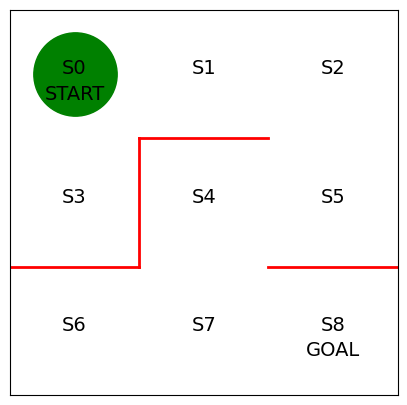

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

plt.plot([0, 1], [1, 1], color='red', linewidth=2)
plt.plot([1, 1], [1, 2], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', size=14, ha='center')
plt.text(2.5, 0.3, 'GOAL', size=14, ha='center')

plt.axis('on')
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    right=False,
    left=False,
    labelbottom=False,
    labelleft=False
)

line, = ax.plot([.5], [2.5], marker='o', color='g', markersize=60)

#### Agent action policy
* $\pi_{\theta}(s, a)$
  * $s$: $S_0 \rightarrow S8$, discrete and finite ($3 \times 3$, grid world)
  * $a$: $[0, 1, 2, 3]$, $\uparrow$, $\rightarrow$, $\downarrow$, $\leftarrow$
  * representation
    * function: `nn`
    * table: `state * action` matrix $\star$

In [ ]:
import numpy as np

# border & barrier
theta_0 = np.asarray([
    [np.nan, 1, 1, np.nan],       # S0
    [np.nan, 1, np.nan, np.nan],  # S1
    [np.nan, np.nan, 1, 1],       # S2
    [1, np.nan, np.nan, np.nan],  # S3
    [np.nan, 1, 1, np.nan],       # S4
    [1, np.nan, np.nan, 1],       # S5
    [np.nan, 1, np.nan, np.nan],  # S6
    [1, 1, np.nan, 1]             # S7
])

def convert_theta_0_to_pi(theta):
    m, n = theta.shape
    pi = np.zeros((m , n))
    for r in range(m):
        pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
    return np.nan_to_num(pi)

def step(state, action):
    if action == 0:
        state -= 3
    elif action == 1:
        state += 1
    elif action == 2:
        state += 3
    elif action == 3:
        state -= 1
    return state
    
actions = list(range(4))
pi = convert_theta_0_to_pi(theta_0)
state = 0
action_history = []
state_history = [state]
while True:
    action = np.random.choice(actions, p=pi[state, :])
    state = step(state, action)
    if state == 8:
        state_history.append(state)
        break
    action_history.append(action)
    state_history.append(state)

In [ ]:
len(state_history)

13

#### Rendering & animation

In [ ]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([[]], [[]])
    return (line, )

def animate(i):
    state = state_history[i]
    x = (state % 3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data([x], [y])

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(state_history), interval=200, repeat=False)
anim.save('maze_0.mp4')
HTML(anim.to_jshtml())

### MazeEnv Agent

In [ ]:
from typing import Tuple
import gym
import numpy as np
import matplotlib.pyplot as plt

class MazeEnv(gym.Env):
    def __init__(self) -> None:
        super().__init__()
        self.state = 0

    def reset(self) -> int:
        self.state = 0
        return self.state
    
    def step(self, action):
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        elif action == 3:
            self.state -= 1
        done = False
        if self.state == 8:
            done = True
        return self.state, 1, done, {}    


class Agent:
    def __init__(self) -> None:
        self.actions = list(range(4))
        self.theta_0 = np.asarray([
            [np.nan, 1, 1, np.nan],       # S0
            [np.nan, 1, np.nan, np.nan],  # S1
            [np.nan, np.nan, 1, 1],       # S2
            [1, np.nan, np.nan, np.nan],  # S3
            [np.nan, 1, 1, np.nan],       # S4
            [1, np.nan, np.nan, 1],       # S5
            [np.nan, 1, np.nan, np.nan],  # S6
            [1, 1, np.nan, 1]             # S7
        ])
        self.pi = self._convert_theta_0_to_pi(self.theta_0)

    def _convert_theta_0_to_pi(self, theta):
        m, n = theta.shape
        pi = np.zeros((m , n))
        for r in range(m):
            pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
        return np.nan_to_num(pi)

    def choose_action(self, state):
        action = np.random.choice(self.actions, p=self.pi[state, :])
        return action


env = MazeEnv()
state = env.reset()
agent = Agent()

done = False
action_history = []
state_history = [state]
while not done:
    action = agent.choose_action(state)
    state, reward, done, _ = env.step(action)
    action_history.append(action)
    state_history.append(state)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(state_history), interval=200, repeat=False)
HTML(anim.to_jshtml())

### Policy Gradient

* $\theta$与$\pi_{\theta}(s, a)$（给定$\theta$ 特征参数 关于$s$，$a$的函数），基于$\theta$找到$\pi_{\theta}$
  * $\theta$是策略参数
  * $\pi_{\theta}(s, a)$是策略（base $\theta$, policy）
  * $\pi$表示分布
* 策略迭代（策略梯度，plolicy gradient）的含义
  * $\theta_0 \rightarrow \pi_0, \theta_0 \rightarrow \theta_1, \theta_1 \rightarrow \pi_1$

#### 基于占比，最朴素（naive）的概率化方式

def convert_theta_0_to_pi(theta):
    m, n = theta.shape
    pi = np.zeros((m , n))
    for r in range(m):
        pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
    return np.nan_to_num(pi)

#### 基于softmax，更general的概率化方式
$$
\begin{align}
P_k &= \frac{exp(z_k \cdot \beta)}{\sum_i{exp(z_i \cdot \beta)}} \\
    &= \frac{exp(\tfrac{z_k}{T})}{\sum_i{exp(\tfrac{z_i}{T})}} \\
    &= \frac{exp(\beta \cdot z_k)}{\sum_i{exp(\beta \cdot z_i)}} \\
\end{align}
$$

In [ ]:
def soft_convert_theta_0_to_pi(theta, beta=1.0):
    m, n = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(theta * beta)
    for r in range(m):
        pi[r, :] = exp_theta[r, :] / np.nansum(exp_theta[r, :])
    pi = np.nan_to_num(pi)
    return pi

#### 参数$\theta$更新
$\theta_{s_i, a_i} = \theta_{s_i, a_i} + \eta \cdot \Delta \theta_{s, a_i}$ <br>
$\Delta \theta_{s, a_i} = \frac{1}{T} \cdot (N(s_i, a_j) - P(s_i, a_j)N(s_i, a))$

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt


class MazeEnv(gym.Env):
    def __init__(self) -> None:
        super().__init__()
        self.state = 0

    def reset(self) -> int:
        self.state = 0
        return self.state
    
    def step(self, action):
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        elif action == 3:
            self.state -= 1
        done = False
        if self.state == 8:
            done = True
        return self.state, 1, done, {}    
    
class Agent:
    def __init__(self) -> None:
        self.actions = list(range(4))
        self.theta_0 = np.asarray([
            [np.nan, 1, 1, np.nan],       # S0
            [np.nan, 1, np.nan, np.nan],  # S1
            [np.nan, np.nan, 1, 1],       # S2
            [1, np.nan, np.nan, np.nan],  # S3
            [np.nan, 1, 1, np.nan],       # S4
            [1, np.nan, np.nan, 1],       # S5
            [np.nan, 1, np.nan, np.nan],  # S6
            [1, 1, np.nan, 1]             # S7
        ])
        self.eta = 0.1
        self.theta = self.theta_0
        self.pi = self._softmax_convert_theta_0_to_pi()

    def _convert_theta_0_to_pi(self, theta):
        m, n = theta.shape
        pi = np.zeros((m , n))
        for r in range(m):
            pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
        return np.nan_to_num(pi)
    
    def _softmax_convert_theta_0_to_pi(self, beta=1.0):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        exp_theta = np.exp(self.theta * beta)
        for r in range(m):
            pi[r, :] = exp_theta[r, :] / np.nansum(exp_theta[r, :])
        pi = np.nan_to_num(pi)
        return pi
    
    def update_theta(self, s_a_history):
        T = len(s_a_history) - 1
        m, n = self.theta.shape
        delta_theta = self.theta.copy()
        for i in range(m):
            for j in range(n):
                if not(np.isnan(self.theta_0[i, j])):
                    sa_i = [sa for sa in s_a_history if sa[0] == i]
                    sa_ij = [sa for sa in s_a_history if (sa[0] == i and sa[1] == j)]
                    N_i = len(sa_i)
                    N_ij = len(sa_ij)
                    delta_theta[i, j] = (N_ij - self.pi[i, j] * N_i) / T
        self.theta = self.theta + self.eta + delta_theta
        return self.theta
    
    def update_pi(self):
        self.pi = self._softmax_convert_theta_0_to_pi()

    def choose_action(self, state):
        action = np.random.choice(self.actions, p=self.pi[state, :])
        return action
    

env = MazeEnv()
agent = Agent()
step_eps = 1e-4
while True:
    state = env.reset()
    s_a_history = [[state, np.nan]]
    while True:
        action = agent.choose_action(state)
        s_a_history[-1][1] = action
        state, reward, done, _ = env.step(action)
        s_a_history.append([state, np.nan])
        if state == 8 or done:
            break
    agent.update_theta(s_a_history)
    pi = agent.pi.copy()
    agent.update_pi()
    delta = np.sum(np.abs(pi - agent.pi))
    print(len(s_a_history), delta)
    if delta < step_eps:
        break


In [ ]:
pi = agent.pi
pi

array([[0.        , 0.99541232, 0.00458768, 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.99741565, 0.00258435],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00970233, 0.99029767, 0.        ],
       [0.00381682, 0.        , 0.        , 0.99618318],
       [0.        , 1.        , 0.        , 0.        ],
       [0.00145353, 0.99576995, 0.        , 0.00277653]])

### 基本概念及术语
* reward
  * 特定时间$t$给到的奖励$R_t$称为即时奖励（immediate reward）
  * 未来的总奖励$G_t$
    * $G_t = R_{t + 1} + R_{t + 2} + R_{t + 3} + \cdots$
    * $G_t = R_{t + 1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \cdots + \gamma^k R_{t + k + 1} + \cdots$
  * 举例
    * $Q_{\pi}(s = 7, a = 1) = R_{t + 1} = 1$
    * $Q_{\pi}(s = 7, a = 0) = \gamma^2$
* action value, state value
* bellman equation
  * 适用于状态价值函数（state value function），也适用于动作价值函数（action value function）
* mdp: markov decision process
  * 马尔可夫性
    * $p(s_{t + 1}|s_t) = p(s_{t + 1}|s_1, s_2, s_3, \cdots, s_t)$
    * $t$时刻的状态转移到$t + 1$时刻的状态应该和前面的状态无关，只和$t$时刻的状态有关
    * bellman equation 成立的前提条件
### SARSA
state, action reward, state, action
* $R_t$
* $Q_{\pi}(s, a)$: state action value funciton
  * Q table
  * 通过 Sarsa 算法迭代更新$Q_{pi}(s, a)$
* 对于强化学习而言
  * state, action, reward 都是需要精心设计的

In [ ]:
import numpy as np

theta_0 = np.asarray([
    [np.nan, 1, 1, np.nan],       # S0
    [np.nan, 1, np.nan, np.nan],  # S1
    [np.nan, np.nan, 1, 1],       # S2
    [1, np.nan, np.nan, np.nan],  # S3
    [np.nan, 1, 1, np.nan],       # S4
    [1, np.nan, np.nan, 1],       # S5
    [np.nan, 1, np.nan, np.nan],  # S6
    [1, 1, np.nan, 1]             # S7
])

n_states, n_actions = theta_0.shape
Q = np.random.rand(n_states, n_actions) * theta_0
Q

array([[       nan, 0.89526567, 0.85458108,        nan],
       [       nan, 0.69141077,        nan,        nan],
       [       nan,        nan, 0.90761197, 0.57464978],
       [0.80707793,        nan,        nan,        nan],
       [       nan, 0.54164057, 0.40533904,        nan],
       [0.93912137,        nan,        nan, 0.4673623 ],
       [       nan, 0.76428396,        nan,        nan],
       [0.1730892 , 0.83239731,        nan, 0.94642327]])

#### $\epsilon$-greedy (explore, exploit)

In [ ]:
def convert_theta_0_to_pi(theta):
    m, n = theta.shape
    pi = np.zeros((m, n))
    for r in range(m):
        pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
    return np.nan_to_num(pi)

# epsilon-greedy
def get_action(s, Q, epsilon, pi_0):
    action_spaces = list(range(4))
    # epsilon, explore
    if np.random.rand() < epsilon:
        action = np.random.choice(action_spaces, p=pi_0[s, :])
    else:
        # 1 - epsilon, exploit
        action = np.nanargmax(Q[s, :]) # 选择非nan的最大的参数作为action

    return action

pi_0 = convert_theta_0_to_pi(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

#### Sarsa (Update $Q_{\pi}(s, a)$)
理想情况下：
$$Q(s_t, a_t) = R_{t + 1} + \gamma Q(s_{t + 1}, a_{t + 1})$$
* td (temporal difference error) 现实情况是存在TD Error的
  * $R_{t + 1}  + \gamma Q(s_{t + 1}, a_{t + 1}) - Q(s_t, a_t)$
* final update equation 是一个迭代的过程，不断地更新当前Q-Table中的value，$eta$是学习率
  * $Q(s_t, a_t) = Q(s_t, a_t) + \eta \cdot (R_{t + 1} + \gamma Q(s_{t + 1}, a_{t + 1}) - Q(s_t, a_t))$
  * $s_t, a_t, r_{t + 1}, a_{t + 1}$
* 折扣（discount factor, $\gamma$）,有助于缩短步数，更快地结束任务（王树森：距离当前状态越远的回报越不重要，通过乘上迭代因子，是较远的汇报不会影响当前的状态更新）

In [ ]:
def sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    if a_next == 8: # 将Q[s_next, a_next]置为0
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

### Q learning
- sarsa: $Q(s_t, a_t) = Q(s_t, a_t) + \eta \cdot (R_{t + 1} + \gamma Q(s_{t + 1}, a_{t + 1}) - Q(s_t, a_t))$
  - 策略依赖型（on）
- Q learning: $Q(s_t, a_t) = Q(s_t, a_t) + \eta \cdot (R_{t + 1} + \gamma \max_a{Q(s_{t + 1}, a)} - Q(s_t, a_t))$
  - 策略关闭型（off）

### 解决 Maze 问题

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt


class MazeEnv(gym.Env):
    def __init__(self) -> None:
        super().__init__()
        self.state = 0

    def reset(self) -> int:
        self.state = 0
        return self.state
    
    def step(self, action):
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        elif action == 3:
            self.state -= 1
        done = False
        reward = 0
        if self.state == 8:
            done = True
            reward = 1
        return self.state, reward, done, {}    
    
class Agent:
    def __init__(self) -> None:
        self.action_spaces = list(range(4))
        self.theta = np.asarray([
            [np.nan, 1, 1, np.nan],       # S0
            [np.nan, 1, np.nan, 1],       # S1
            [np.nan, np.nan, 1, 1],       # S2
            [1, np.nan, np.nan, np.nan],  # S3
            [np.nan, 1, 1, np.nan],       # S4
            [1, np.nan, np.nan, 1],       # S5
            [np.nan, 1, np.nan, np.nan],  # S6
            [1, 1, np.nan, 1]             # S7
        ])
        self.eta = 0.1
        self.Q = np.random.rand(*self.theta.shape) * self.theta
        self.pi = self._convert_theta_0_to_pi()
        self.eta = 0.1
        self.gamma = 0.9
        self.epsilon = 0.5

    def _convert_theta_0_to_pi(self):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        for r in range(m):
            pi[r, :] = self.theta[r, :] / np.nansum(self.theta[r, :])
        return np.nan_to_num(pi)
    
    def get_action(self, s):
        # epsilon, explore
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_spaces, p=self.pi[s, :])
        else:
            # 1 - epsilon, exploit
            action = np.nanargmax(self.Q[s, :]) # 选择非nan的最大的参数作为action
        return action
    
    def sarsa(self, s, a, r, s_next, a_next):
        if s_next == 8: # 将Q[s_next, a_next]置为0
            self.Q[s, a] = self.Q[s, a] + self.eta * (r - self.Q[s, a])
        else:
            self.Q[s, a] = self.Q[s, a] + self.eta * (r + self.gamma * self.Q[s_next, a_next] - self.Q[s, a])
    
    def q_learning(self, s, a, r, s_next):
        if s_next == 8: # 将Q[s_next, a_next]置为0
            self.Q[s, a] = self.Q[s, a] + self.eta * (r - self.Q[s, a])
        else:
            self.Q[s, a] = self.Q[s, a] + self.eta * (r + self.gamma * np.nanmax(self.Q[s_next, :]) - self.Q[s, a])

env = MazeEnv()
agent = Agent()
step_eps = 1e-5
epoch = 0
while True:
    old_Q = np.nanmax(agent.Q, axis=1)
    state = env.reset()
    action = agent.get_action(state)
    s_a_history = [[state, np.nan]]
    while True:
        s_a_history[-1][1] = action
        s_next, reward, done, _ = env.step(action)
        s_a_history.append([state, np.nan])
        if done:
            a_next = np.nan
        else:
            a_next = agent.get_action(s_next)
        # print("state: {}, action: {}, reward: {}, state next: {}, action next: {}".format(state, action, reward, s_next, a_next))
        # agent.sarsa(state, action, reward, s_next, a_next)
        agent.q_learning(state, action, reward, s_next)
        if done:
            break
        else:
            action = a_next
            s = env.state
    update = np.sum(np.abs(np.nanmax(agent.Q, axis=1) - old_Q))
    epoch += 1
    agent.epsilon /= 2
    print(epoch, update, len(s_a_history))
    if epoch > 100 or update < step_eps:
        break


1 0.3969946358867419 151
2 0.04794612123903408 133
3 0.0045946340032387845 117
4 0.03443967892420008 685
5 0.05449738145685423 803
6 0.0002458977956059094 651
7 0.012437379911240165 2007
8 0.012714619543213956 11469
9 0.0 2419


### Cart Pole

In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
from matplotlib import animation

from JSAnimation.IPython_display import display_animation
from IPython.display import display, HTML

#### 重新认识 cartpole 环境
- 小滑块/倒立板
- 典型的 MDP（Markov Decision Process）
  - 下一时刻的状态（转移）$s_{t + 1}$只跟当前状态$s_t$和$s_t$（当前状态下采取的动作）有关
- action space is discrete and finite
- state (observation) space is continuous

#### One Episode

In [ ]:
env = gym.make('CartPole-v0', render_mode="rgb_array")
state = env.reset()
steps = 0
frames = []
while True:
    frames.append(env.render())
    action = env.action_space.sample()
    observation, state, reward, done, info = env.step(action)
    steps += 1
    print(f'steps: {steps}, state: {observation}')
    if done:
        break

In [ ]:
def display_frames_as_gif(frames, output):
    fig = plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        img = patch.set_data(frames[i])
        return img
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(output)
    return HTML(anim.to_jshtml())

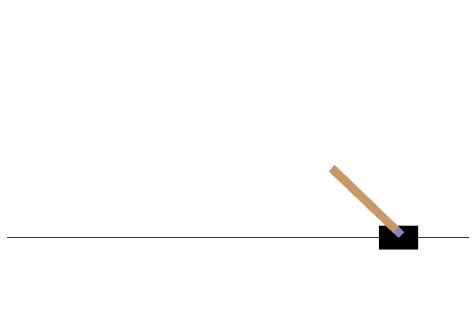

In [ ]:
display_frames_as_gif(frames, output='rand_cartpole.gif')

#### 状态离散化

In [ ]:
NUM_DIGITIZED = 6

# 分桶，5个值对应6个分段，即6个桶
def bins(clip_min, clip_max, num_bins=NUM_DIGITIZED):
    return np.linspace(clip_min, clip_max, num_bins + 1)[1:-1]

# 按6进制映射，将4位6进制映射为id
def digitize_state(observation):
    pos, cart_v, angle, pole_v = observation
    digitize = [
        np.digitize(pos, bins=bins(-2.4, 2.4, NUM_DIGITIZED)),
        np.digitize(cart_v, bins=bins(-3, 3, NUM_DIGITIZED)),
        np.digitize(angle, bins=bins(-0.418, 0.418, NUM_DIGITIZED)),
        np.digitize(pole_v, bins=bins(-2, 2, NUM_DIGITIZED)),
    ]
    ind = sum([d * (NUM_DIGITIZED ** i) for i, d in enumerate(digitize)])
    return ind

#### Q-Learning

In [ ]:
class Agent:

    def __init__(self, action_space, n_states, eta=0.5, gamma=0.09, NUM_DIGITIZED=6) -> None:
        self.eta = eta
        self.gamma = gamma
        self.action_space = action_space
        self.NUM_DIGITIZED = NUM_DIGITIZED
        self.q_table = np.random.uniform(0, 1,size=(NUM_DIGITIZED ** n_states, self.action_space.n))

    @staticmethod
    # 分桶，5个值对应6个分段，即6个桶
    def bins(clip_min, clip_max, num_bins):
        return np.linspace(clip_min, clip_max, num_bins + 1)[1:-1]

    # 按6进制映射，将4位6进制映射为id
    @staticmethod
    def digitize_state(observation, NUM_DIGITIZED):
        pos, cart_v, angle, pole_v = observation
        digitize = [
            np.digitize(pos, bins=Agent.bins(-2.4, 2.4, NUM_DIGITIZED)),
            np.digitize(cart_v, bins=Agent.bins(-3, 3, NUM_DIGITIZED)),
            np.digitize(angle, bins=Agent.bins(-0.418, 0.418, NUM_DIGITIZED)),
            np.digitize(pole_v, bins=Agent.bins(-2, 2, NUM_DIGITIZED)),
        ]
        ind = sum([d * (NUM_DIGITIZED ** i) for i, d in enumerate(digitize)])
        return ind
    
    def q_learning(self, obs, action, reward, obs_next):
        obs_ind = Agent.digitize_state(obs, self.NUM_DIGITIZED)
        obs_next_ind = Agent.digitize_state(obs_next, self.NUM_DIGITIZED)
        self.q_table[obs_ind, action] = self.q_table[obs_ind, action] +\
            self.eta * (reward + max(self.q_table[obs_next_ind, :]) - self.q_table[obs_ind, action])

    def choose_action(self, state, episode):
        eps = 0.5 * 1 / (episode + 1)
        state_ind = Agent.digitize_state(state, self.NUM_DIGITIZED)
        if random.random() < eps:
            action = self.action_space.sample()
        else:
            action = np.argmax(self.q_table[state_ind, :])
        return action


In [ ]:
env = gym.make('CartPole-v0', render_mode="rgb_array")
env.reset()
action_space = env.action_space
n_states = env.observation_space.shape[0]
agent = Agent(action_space, n_states)

max_episode = 1000
max_steps = 200

continue_success_episodes = 0
learning_finish_flag = False
frames = []

for episode in range(max_episode):
    obs = env.reset()
    obs = obs[0]
    for step in range(max_steps):
        if learning_finish_flag:
            frames.append(env.render())
        action = agent.choose_action(obs, episode)
        obs_next, _, done, _, _ = env.step(action)
        if done:
            if step < 150:
                reward -= 1
                continue_success_episodes = 0
            else:
                reward = 1
                continue_success_episodes += 1
        else:
            reward = 0

        agent.q_learning(obs, action, reward, obs_next)
        obs = obs_next

        if done:
            print(f'episode: {episode}, finish {step} time steps.')
            break

    if learning_finish_flag:
        break
    if continue_success_episodes >= 10:
        learning_finish_flag = True
        print(f'continue success(step > 195) more than 10 times.')


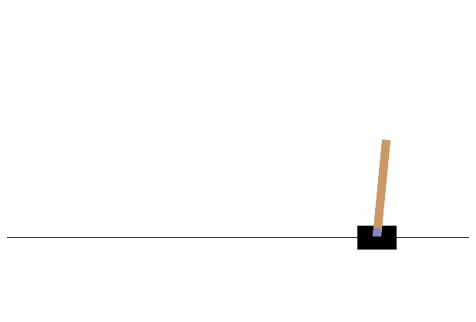

In [ ]:
display_frames_as_gif(frames, output='q_learning_cartpole.gif')

## DQN

### Outline & Summary
* Q-Learning => DQN(Deep Q Learning Network)
* Q-Learning base q-table
  * state 需要处理成离散的（discrete）
  * q-table：行是 state，列是 action
  * $Q(s, a)$：动作价值（value），不是概率分布
  * $Q(s_t, a_t)$是在时刻$t$，状态$s_t$下采取的动作$a_t$时获得的折扣奖励总和（discounted total reward）
  * Image（pixels）作为状态的话，状态变量的数量非常大
* DQN：nn（state）=> action value
  * q-table => q-function（拟合/回归，state vector 与 action value 的关系）
  * 输入 & 输出：
    * 输入（input）：state vector
      * CartPole：4维向量（位置、速度、角度和角速度）
    * 输出（output）：action space value, $Q(s_t, a_t)$
      * shape：action space size
      * CartPole：2维（left/right）
  
### DQN 算法

$$
\begin{align}
Q(s_t, a_t) &= Q(s_t, a_t) + \eta \cdot (R_{t + 1} + \gamma \max_a{Q(s_{t + 1}, a)} - Q(s_t, a_t)) \\
Q(s_t, a_t) &= R_{t + 1} + \gamma \max_a{Q(s_{t + 1}, a)}
\end{align}
$$

* iteration algorithm
* temporal difference error (TD): $R_{t + 1} + \gamma \max_a{Q(s_{t}, a)} - Q(s_t, a_t)$
* learning objective
  * MES (square loss): $E(s_t, a_t) = (R_{t + 1} + \gamma \max_a{Q(s_{t}, a)} - Q(s_t, a_t))^2$

#### 几个核心技术

* experience replay （经验回放）
  * 不像 q-table 的 Q-Learning，每一步都学习（update）该步的内容（experience）
    * 对于 q-table 而言，每一步（step）都学习该步内容，神经网络连续地学习时间上相关性高的内容（事实上，时间$t$的学习内容和时间$t + 1$的学习内容非常相似，这样的话收敛就会很慢）
    * 而是将每一步（step）的内容存储在经验池（experience pool）并随即从经验池中提取内容（replay，回放）让 NN 学习
      * 也可以使用批次（batch），使用经验池中的多个步骤的经验
* loss function 使用 huber 而不是 square loss
  * 误差很大时（$|\delta| > 1$），平方差会导致误差函数的输出过大，导致学习难以确定

$$
\mathcal{L}(\delta) = 
\begin{cases}
\frac{1}{2} \delta ^2, & |\delta| \leq 1 \\
|\delta| - \frac{1}{2}, & |\delta| > 1
\end{cases}
$$

  $\delta$就是$Q(s_t, a_t)$和$R_{t + 1} + \gamma \max_a{Q(s_{t + 1}, a)}$的差

> 解决深度强化学习的稳定性问题

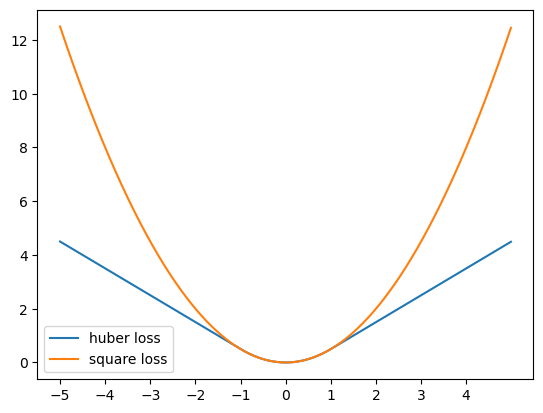

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def huber_loss(delta, beta=1):
    if np.abs(delta) <= beta:
        return 0.5 * delta ** 2 / beta
    return abs(delta) - 0.5 * beta


def square_loss(delta):
    return 0.5 * delta ** 2

deltas = np.arange(-5, 5, 0.01)
plt.plot(deltas, [huber_loss(delta) for delta in deltas])
plt.plot(deltas, [square_loss(delta) for delta in deltas])
plt.xticks(np.arange(-5, 5, step=1))
plt.legend(['huber loss', 'square loss'])

### 实现
#### experience replay
- 构造批次化训练数据
- 让整个训练过程更加稳定

In [1]:
from collections import namedtuple
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch
import random

In [2]:
# 可以使用关键字访问
# s_t, a_t = s_{t + 1}
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [9]:
t = []
for i in range(32):
    t.append(Transition(torch.tensor([1, 2, 3, 4]), 2, 3, 4))

t = random.sample(t, 4)
t = Transition(*zip(*t))
print(t.state)
state = torch.cat(t.state)
state.shape

(tensor([1, 2, 3, 4]), tensor([1, 2, 3, 4]), tensor([1, 2, 3, 4]), tensor([1, 2, 3, 4]))


torch.Size([16])

每次和环境交互产生的一次Transition，都放到经验回放池中，用于批次化的训练，增加训练过程的稳定性

In [3]:
class ReplayMemory:
    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self.memory = []
        self.index = 0

    def __len__(self):
        return len(self.memory)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def push(self, state, action, next_state, reward):
        # 循环的往 memory 中 push
        if len(self.memory) < self.capacity:
            # 占位
            self.memory.append(None)
        self.memory[self.index] = Transition(state, action, next_state, reward)
        self.index = (self.index + 1) % self.capacity

In [21]:
# Q function base network
class DQN(nn.Module):
    def __init__(self, n_states, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_states, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        # x.shape: batch_size * n_states
        layer1 = self.fc1(x)
        layer1 = F.relu(layer1)
        layer2 = self.fc2(layer1)
        layer2 = F.relu(layer2)
        layer3 = self.fc3(layer2)
        return layer3

#### Agent

* 计算过程中 tensor shape 的变化以及 shape 的对齐

In [19]:
class Agent:
    def __init__(self, n_states, n_actions, eta=0.5, gamma=0.99, capacity=10000, batch_size=32):
        self.n_states = n_states
        self.n_actions = n_actions
        self.eta = eta
        self.gamma = gamma
        self.batch_size = batch_size

        self.memory = ReplayMemory(capacity)
        self.model = DQN(n_states, n_actions)

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def _replay(self):
        if len(self.memory) < self.batch_size:
            return
        # list of transition
        batch = self.memory.sample(self.batch_size)
        # Transition, column: tuple -> len(tuple) == batch_size
        batch = Transition(*zip(*batch))

        # s_t.shape: batch_size * 4
        state_batch = torch.cat(batch.state)
        # a_t.shape: batch_size * 1
        action_batch = torch.cat(batch.action)
        # r_{t + 1}.shape: batch_size * 1
        reward_batch = torch.cat(batch.reward)
        # < batch_size
        non_final_next_state_batch = torch.cat([s for s in batch.next_state if s is not None])

        # 构造模型训练用的输入和输出
        # s_t: input
        # pred: Q(s_t, a_t)
        # true; R_{t + 1} + \gamma \max_a{Q(s_{t + 1}, a)}

        # 开启 eval 模式
        self.model.eval()

        # pred
        state_action_values = self.model(state_batch).gather(dim=1, index=action_batch)
        
        # true; R_{t + 1} + \gamma \max_a{Q(s_{t + 1}, a)}
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
        next_state_values = torch.zeros(self.batch_size)
        next_state_values[non_final_mask] = self.model(non_final_next_state_batch).max(dim=1)[0].detach()
        expected_state_action_values = reward_batch + self.gamma * next_state_values

        # 开启 train mode
        self.model.train()

        # (batch_size, ) => (batch_size, 1)
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_q_function(self):
        self._replay()

    # action policy
    # epsilon greedy
    # double e: explore, exploit
    def choose_action(self, state, episode):
        eps = 0.5 * 1 /  (1 + episode)
        if random.random() < eps:
            action = torch.IntTensor([[random.randrange(self.n_actions)]])
        else:
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)

        return action
    
    def memorize(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)

Agent 与 env 进行交互

In [6]:
import gym
gym.__version__

'0.26.2'

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

max_episode = 500
max_steps = 200
complete_episode = 0

agent = Agent(n_states, n_actions)

for episode in range(max_episode):
    state = env.reset()
    state = torch.from_numpy(state[0]).type(torch.FloatTensor).unsqueeze(0)
    for step in range(max_steps):
        # IntTensor of 1 * 1
        action = agent.choose_action(state, episode)

        # transition on env
        next_state, _, done, _, _ = env.step(action.item())

        if done:
            next_state = None
            if step < 195:
                reward = torch.FloatTensor([-1, 1])
                complete_episode = 0
            else:
                reward = torch.FloatTensor([1.])
                complete_episode += 1
        else:
            reward = torch.FloatTensor([0])
            next_state = torch.from_numpy(next_state).type(torch.FloatTensor)
            next_state = next_state.unsqueeze(0)
        agent.memorize(state, action, next_state, reward)
        state = next_state

        if done:
            print(f'episode: {episode}, steps: {step}')
            break

    if complete_episode >= 10:
        print('连续成功10轮')
        break
